# Import Libraries

In [1]:
import torch
print(torch.__version__)
import torchvision
import torch.nn as nn

import os
import sys
import time

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

1.8.1


# GPU/CUDA setup

In [2]:
if torch.cuda.is_available():
    print("CUDA enabled!")
device = 'cuda:0'
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(f'{i}' for i in range(1))

CUDA enabled!


# Autoencoder Helpers

In [3]:
"""
Adopted from @author Oscar Li

Source: https://github.com/OscarcarLi/PrototypeDL
"""
def makedirs(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

def list_of_distances(X, Y):
    '''
    Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
    Y = [y_1, ... , y_m], we return a list of vectors
            [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
             ...
             [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
    where the distance metric used is the sqared euclidean distance.
    The computation is achieved through a clever use of broadcasting.
    '''
    XX = torch.reshape(list_of_norms(X), shape=(-1, 1))

    YY = torch.reshape(list_of_norms(Y), shape=(1, -1))
    output = XX + YY - 2 * torch.matmul(X, torch.transpose(Y, 0, 1))
    return output

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X, 2),dim=1)

def print_and_write(str, file):
    '''
    print str to the console and also write it to file
    '''
    print(str)
    file.write(str + '\n')



# Network Modules

In [4]:
class EncoderLayer(nn.Module):
    def __init__(self, in_channels=1, n_maps=32, out_channels=10, n_layers=4):
        super(EncoderLayer, self).__init__()
        
        el = []
        el += [ConvLayer(in_channels, n_maps, stride=2, padding=1)]
        for i in range(0, n_layers-2):
            el += [ConvLayer(n_maps, n_maps, stride=2, padding=1)]   
        el += [ConvLayer(n_maps, out_channels, stride=2, padding=1)]

        self.encoder = nn.Sequential(*el)

    def forward(self, x):
        return self.encoder(x)

class DecoderLayer(nn.Module):
    def __init__(self, in_channels=10, n_maps=32, out_channels=1, out_shapes=[], n_layers=4):
        super(DecoderLayer, self).__init__()

        dl = []
        dl += [DeConvLayer(in_channels, n_maps, out_shape=out_shapes[-1], stride=2, padding=1, output_padding=1)]
        for i in range(1, n_layers-1):
            dl += [DeConvLayer(n_maps, n_maps, out_shape=out_shapes[-(i+1)], stride=2, padding=1, output_padding=1)]
        dl += [DeConvLayer(n_maps, out_channels, out_shape=out_shapes[-n_layers], stride=2, padding=1, 
                           output_padding=1, activation=nn.Sigmoid)]

        self.decoder = nn.Sequential(*dl)

    def forward(self, x):
        return self.decoder(x)

class PrototypeLayer(nn.Module):
    def __init__(self, in_channels=10, n_prototypes=15):
        super(PrototypeLayer, self).__init__()

        self.prototype_distances = torch.rand(n_prototypes, in_channels, requires_grad=True).to(device)

    def forward(self, x):
        return list_of_distances(x, self.prototype_distances)

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, padding=1, activation=nn.ReLU):
        super(ConvLayer, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3,
                             stride=stride, padding=padding)
        self.activation = activation()

    def forward(self, x):
        self.in_dim = x.shape[-2:]
        return self.activation(self.conv(x)) 

class DeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, out_shape, stride=2, padding=1, output_padding=1, activation=nn.ReLU):
        super(DeConvLayer, self).__init__()
        self.out_shape = out_shape
        self.dconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, 
                                        stride=stride, padding=padding, output_padding=output_padding)
        self.activation = activation()

    def forward(self, x):
        out_convt = self.dconv(x)
        if (out_convt.shape[-2:][0] != self.out_shape[0]) & (out_convt.shape[-2:][1] != self.out_shape[1]):
            out_convt = out_convt[:,:,(out_convt.shape[-2:][0] - self.out_shape[0]):,
                                 (out_convt.shape[-2:][1] - self.out_shape[1]):]
        return self.activation(out_convt)

class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features=15, out_features=10):
        super(FullyConnectedLayer, self).__init__()

        self.linear = nn.Linear(in_features=in_features, out_features=out_features)

    def forward(self, x):
        return self.linear(x)

class Softmax(nn.Module):
    def __init__(self):
        super(Softmax, self).__init__()

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(x)

# CAE Model definition

In [5]:
class CAEModel(nn.Module):
    def __init__(self, input_shape=(1, 1, 28,28), n_maps=32, n_prototypes=15, n_layers=4, n_classes=10):
        super(CAEModel, self).__init__()

        # add encoder layer
        self.encoder = EncoderLayer(in_channels=input_shape[1], n_maps=n_maps, out_channels=n_classes, n_layers=n_layers)
        
        # add prototype layer
        self.in_channels_prototype = self.encoder.forward(torch.randn(input_shape)).view(-1,1).shape[0]
        self.prototype_layer = PrototypeLayer(in_channels=self.in_channels_prototype, n_prototypes=n_prototypes)

        # add decoder layer
        decoder_out_shapes = []
        for layer in self.encoder.modules():
            if isinstance(layer, ConvLayer):
                decoder_out_shapes += [list(layer.in_dim)]
        self.decoder = DecoderLayer(in_channels=n_classes, n_maps=n_maps, out_channels=input_shape[1], out_shapes=decoder_out_shapes)
        
        # output layer
        # add final fully connected layer
        self.fc = FullyConnectedLayer(in_features=n_prototypes, out_features=n_classes)
        self.feature_vectors = None

    def forward(self, x):
        encoder_out = self.encoder(x)
        self.feature_vectors = encoder_out
        prototype_out = self.prototype_layer(encoder_out.view(-1,self.in_channels_prototype))
        fc_out = self.fc(prototype_out)
        return fc_out

# Data Processing

In [6]:
"""
Adopted from @author Oscar Li

Source: https://github.com/OscarcarLi/PrototypeDL
"""
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    '''
    this code is borrowed from chsasank on GitHubGist
    Elastic deformation of images as described in [Simard 2003].
    
    images: a two-dimensional numpy array; we can think of it as a list of flattened images
    sigma: the real-valued variance of the gaussian kernel
    alpha: a real-value that is multiplied onto the displacement fields
    
    returns: an elastically distorted image of the same shape
    '''
    assert len(images.shape) == 2
    # the two lines below ensure we do not alter the array images
    e_images = np.empty_like(images)
    e_images[:] = images
    
    e_images = e_images.reshape(-1, height, width)
    
    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]
    
    for i in range(e_images.shape[0]):
        
        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(-1, height*width)

# MINIST Data Loader

In [7]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# function to load and return train and val multi-process iterator over the MNIST dataset.

def get_train_val_loader(data_dir, batch_size, random_seed, augment=False, val_size=0.2, 
                         shuffle=True, show_sample=False, num_workers=0, pin_memory=True):

    # load the dataset
    train_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=transforms.ToTensor())
    val_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=transforms.ToTensor())

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(val_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # create data iterator
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, 
                                               num_workers=num_workers, pin_memory=pin_memory)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, 
                                             num_workers=num_workers, pin_memory=pin_memory)
    return (train_loader, val_loader)

# function to load and return a multi-process test iterator over the MNIST dataset.
def get_test_loader(data_dir, 
                    batch_size,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True):

    dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                                              num_workers=num_workers, pin_memory=pin_memory)
    return data_loader

# The directory to save the model

In [8]:
model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model", "mnist_cae_1")
makedirs(model_folder)
img_folder = os.path.join(model_folder, "img")
makedirs(img_folder)
model_filename = "mnist_cae"

# console_log is the handle to a text file that records the console output
log_folder=os.path.join(model_folder, "log")
makedirs(log_folder)
console_log = open(os.path.join(log_folder, "console_log.txt"), "w+")

# Model parameters

In [9]:
# training parameters
learning_rate = 0.002
training_epochs = 50 #1500
batch_size = 250              # the size of a minibatch
test_display_step = 100       # how many epochs we do evaluate on the test set once
save_step = 5                # how frequently do we save the model to disk

# elastic deformation parameters
sigma = 4
alpha =20

# lambda's are the ratios between the four error terms
lambda_class = 20
lambda_ae = 1
lambda_1 = 1            # 1 and 2 here corresponds to the notation we used in the paper
lambda_2 = 1

# input data parameters
input_height = 28         # MNIST data input shape
input_width = input_height
n_input_channel = 1       # the number of color channels; for MNIST is 1.
input_size = input_height * input_width * n_input_channel   # the number of pixels in one input image
input_shape = (1, n_input_channel, input_height, input_height) # input shape to pass in the model
n_classes = 10

# Network Parameters
n_prototypes = 15         # the number of prototypes
n_layers = 4
n_maps = 32

# Load MNIST Data

In [10]:
#you may need to install the following packages in your python environment if it fails to donload data.
#conda install -c conda-forge ipywidgets
#jupyter nbextension enable --py widgetsnbextension
# the following two for jupyter hosted environment
#conda install -n base -c conda-forge widgetsnbextension
#conda install -n <your_environment_name> -c conda-forge ipywidgets


In [11]:
# data load and split parameters
random_seed = 1
n_workers = 0
data_folder = 'data'

# download MNIST data
train_loader, val_loader = get_train_val_loader(data_folder, batch_size, random_seed, augment=False, val_size=0.2,
                           shuffle=True, show_sample=False, num_workers=0, pin_memory=True)
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)

C:\Users\mosta\.conda\envs\torchenv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Get the CAE model

In [12]:
model = CAEModel(input_shape=input_shape, n_maps=n_maps, n_prototypes=n_prototypes, 
                 n_layers=n_layers, n_classes=n_classes).to(device)

# Optimizer setup

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model on MNIST data

################################################################################
Epoch: 0001/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:29<00:00,  6.42it/s]
training set errors:	classification error: 2.126816	autoencoder error: 0.055817	error_1: 3.845078	error_2: 1.785094	total error: 48.222313	accuracy: 0.170208
training takes 29.93 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.62it/s]
validation set errors:	classification error: 2.100157	autoencoder error: 0.065795	error_1: 3.882704	error_2: 1.790660	total error: 47.742294	accuracy: 0.308833
################################################################################
Epoch: 0002/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.73it/s]
training set errors:	classification error: 0.629411	autoencoder error: 0.040485	error_1: 2.71501

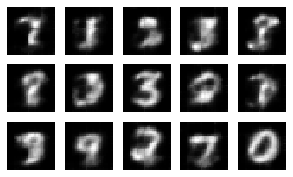

Visualizing encoded and decoded images:


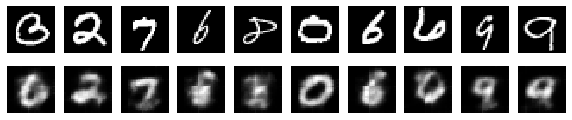

################################################################################
Epoch: 0006/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.65it/s]
training set errors:	classification error: 0.237171	autoencoder error: 0.043555	error_1: 1.685292	error_2: 2.257459	total error: 8.729726	accuracy: 0.943062
training takes 28.86 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 22.76it/s]
validation set errors:	classification error: 0.152216	autoencoder error: 0.047124	error_1: 1.737137	error_2: 2.418810	total error: 7.247400	accuracy: 0.964250
################################################################################
Epoch: 0007/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:30<00:00,  6.38it/s]
training set errors:	classification error: 0.237213	autoencoder error: 0.040934	error_1: 1.386616	

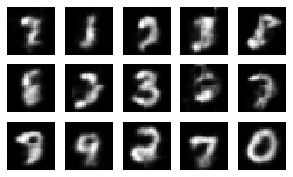

Visualizing encoded and decoded images:


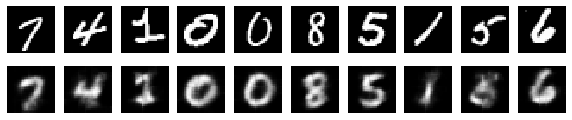

################################################################################
Epoch: 0011/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:33<00:00,  5.79it/s]
training set errors:	classification error: 0.125689	autoencoder error: 0.039559	error_1: 1.253693	error_2: 1.837170	total error: 5.644207	accuracy: 0.961354
training takes 33.15 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 22.36it/s]
validation set errors:	classification error: 0.079858	autoencoder error: 0.046241	error_1: 1.278012	error_2: 1.929402	total error: 4.850818	accuracy: 0.975750
################################################################################
Epoch: 0012/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:31<00:00,  6.15it/s]
training set errors:	classification error: 0.143309	autoencoder error: 0.038099	error_1: 1.204875	

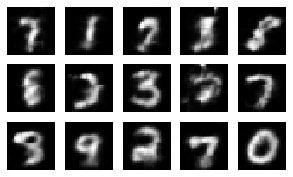

Visualizing encoded and decoded images:


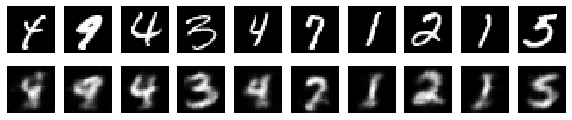

################################################################################
Epoch: 0016/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:27<00:00,  6.94it/s]
training set errors:	classification error: 0.090251	autoencoder error: 0.038288	error_1: 1.043500	error_2: 1.590190	total error: 4.477005	accuracy: 0.966979
training takes 27.67 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 25.10it/s]
validation set errors:	classification error: 0.062488	autoencoder error: 0.044809	error_1: 1.035422	error_2: 1.754575	total error: 4.084573	accuracy: 0.974583
################################################################################
Epoch: 0017/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:27<00:00,  6.95it/s]
training set errors:	classification error: 0.188907	autoencoder error: 0.038857	error_1: 0.952506	

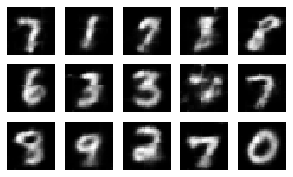

Visualizing encoded and decoded images:


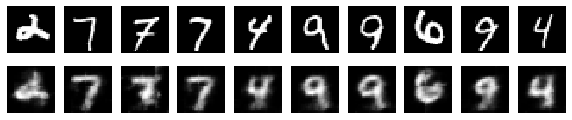

################################################################################
Epoch: 0021/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.77it/s]
training set errors:	classification error: 0.075217	autoencoder error: 0.039146	error_1: 0.800389	error_2: 1.428709	total error: 3.772589	accuracy: 0.969771
training takes 28.38 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.25it/s]
validation set errors:	classification error: 0.088849	autoencoder error: 0.043673	error_1: 0.723590	error_2: 1.433010	total error: 3.977259	accuracy: 0.980167
################################################################################
Epoch: 0022/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.75it/s]
training set errors:	classification error: 0.104536	autoencoder error: 0.037780	error_1: 0.637390	

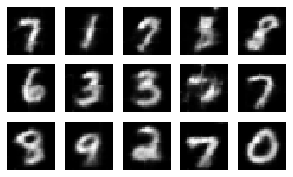

Visualizing encoded and decoded images:


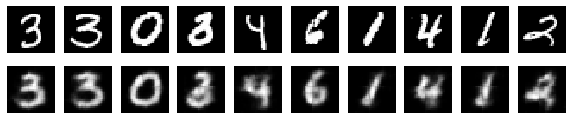

################################################################################
Epoch: 0026/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.78it/s]
training set errors:	classification error: 0.091520	autoencoder error: 0.038886	error_1: 0.680324	error_2: 1.308889	total error: 3.858496	accuracy: 0.972146
training takes 28.33 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.50it/s]
validation set errors:	classification error: 0.032663	autoencoder error: 0.044741	error_1: 0.648624	error_2: 1.245640	total error: 2.592268	accuracy: 0.982000
################################################################################
Epoch: 0027/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.78it/s]
training set errors:	classification error: 0.143067	autoencoder error: 0.038152	error_1: 0.648282	

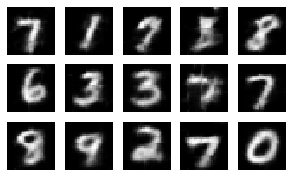

Visualizing encoded and decoded images:


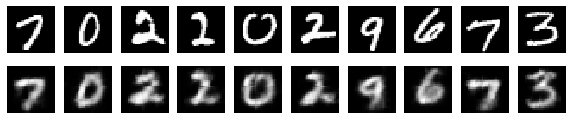

################################################################################
Epoch: 0031/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.77it/s]
training set errors:	classification error: 0.108957	autoencoder error: 0.038037	error_1: 0.431025	error_2: 1.331672	total error: 3.979873	accuracy: 0.973604
training takes 28.36 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.61it/s]
validation set errors:	classification error: 0.041479	autoencoder error: 0.043134	error_1: 0.535413	error_2: 1.139017	total error: 2.547141	accuracy: 0.983833
################################################################################
Epoch: 0032/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.76it/s]
training set errors:	classification error: 0.050319	autoencoder error: 0.036377	error_1: 0.649402	

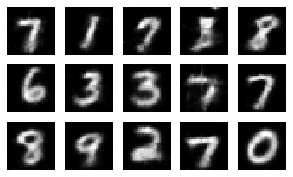

Visualizing encoded and decoded images:


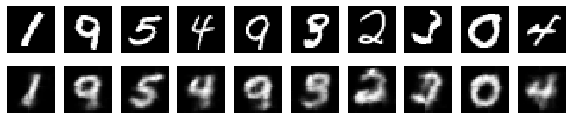

################################################################################
Epoch: 0036/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.79it/s]
training set errors:	classification error: 0.074090	autoencoder error: 0.038333	error_1: 0.534509	error_2: 1.215484	total error: 3.270121	accuracy: 0.976187
training takes 28.30 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.93it/s]
validation set errors:	classification error: 0.070600	autoencoder error: 0.044653	error_1: 0.601427	error_2: 1.167740	total error: 3.225819	accuracy: 0.984167
################################################################################
Epoch: 0037/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.82it/s]
training set errors:	classification error: 0.036711	autoencoder error: 0.038421	error_1: 0.476201	

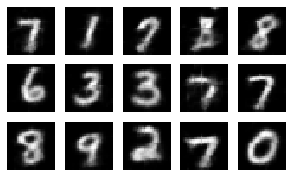

Visualizing encoded and decoded images:


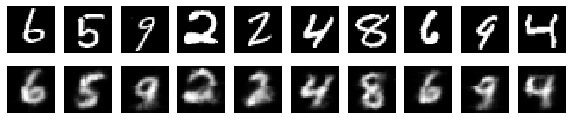

################################################################################
Epoch: 0041/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.76it/s]
training set errors:	classification error: 0.123383	autoencoder error: 0.037378	error_1: 0.450271	error_2: 1.181597	total error: 4.136901	accuracy: 0.977021
training takes 28.41 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.64it/s]
validation set errors:	classification error: 0.063269	autoencoder error: 0.042161	error_1: 0.449383	error_2: 1.110972	total error: 2.867904	accuracy: 0.983083
################################################################################
Epoch: 0042/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.72it/s]
training set errors:	classification error: 0.054102	autoencoder error: 0.038692	error_1: 0.450922	

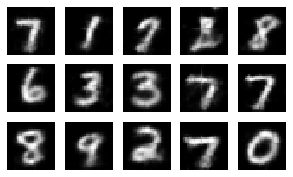

Visualizing encoded and decoded images:


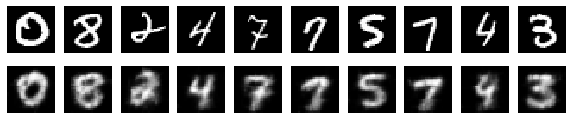

################################################################################
Epoch: 0046/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.83it/s]
training set errors:	classification error: 0.096917	autoencoder error: 0.038877	error_1: 0.369090	error_2: 1.065087	total error: 3.411400	accuracy: 0.976500
training takes 28.12 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.43it/s]
validation set errors:	classification error: 0.089714	autoencoder error: 0.044228	error_1: 0.453658	error_2: 1.037188	total error: 3.329349	accuracy: 0.984500
################################################################################
Epoch: 0047/0050
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:28<00:00,  6.85it/s]
training set errors:	classification error: 0.089770	autoencoder error: 0.037375	error_1: 0.477868	

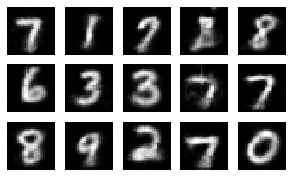

Visualizing encoded and decoded images:


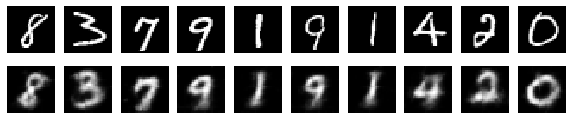

Total taken time 1560.24 seconds.
Optimization Finished!


In [14]:
from tqdm import tqdm, tqdm_notebook

start_time= time.time()

# train the model
for epoch in range(0, training_epochs):
    print_and_write("#"*80, console_log)
    print_and_write("Epoch: %04d" % (epoch+1)+"/%04d" % (training_epochs), console_log)
    n_train_batch = len(train_loader)
    n_val_batch = len(val_loader)
    n_test_batch = len(test_loader)
    start = time.time()

    train_ce, train_ae, train_e1, train_e2, train_te, train_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
        for i, batch in enumerate(train_loader):
            batch_x = batch[0]
            batch_y = batch[1]

            # store original batch shape to put it back into this shape after transformation
            batch_shape = batch_x.shape

            # apply elastic transform
            elastic_batch_x = batch_elastic_transform(batch_x.view(batch_size, -1), sigma=sigma, alpha=alpha, height=input_height, width=input_width)
            elastic_batch_x = torch.reshape(torch.tensor(elastic_batch_x), batch_shape)
            elastic_batch_x = elastic_batch_x.to(device)

            batch_y = batch_y.to(device)

            optimizer.zero_grad()        

            pred_y = model.forward(elastic_batch_x)

            # softmax crossentropy loss
            loss_function = torch.nn.CrossEntropyLoss()
            train_ce = loss_function(pred_y, batch_y)

            prototype_distances = model.prototype_layer.prototype_distances
            feature_vectors = model.feature_vectors

            train_e1 = torch.mean(torch.min(list_of_distances(prototype_distances, feature_vectors.view(-1, model.in_channels_prototype)), dim=1)[0])
            train_e2 = torch.mean(torch.min(list_of_distances(feature_vectors.view(-1, model.in_channels_prototype ), prototype_distances), dim=1)[0])

            out_decoder = model.decoder(feature_vectors)
            train_ae = torch.mean(list_of_norms(out_decoder-elastic_batch_x))

            train_te = lambda_class * train_ce +\
                    lambda_1 * train_e1 +\
                    lambda_2 * train_e2 +\
                    lambda_ae * train_ae

            train_te.backward()

            optimizer.step()

            # train accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            train_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

            pbar.set_description('batch: %03d' % (1 + i))
            pbar.update(1)
    
    train_ac /= n_train_batch
    print_and_write("training set errors:"+"\tclassification error: {:.6f}".format(train_ce)+
                    "\tautoencoder error: {:.6f}".format(train_ae)+
                    "\terror_1: {:.6f}".format(train_e1)+
                    "\terror_2: {:.6f}".format(train_e2)+
                    "\ttotal error: {:.6f}".format(train_te)+
                    "\taccuracy: {:.6f}".format(train_ac), console_log)
    print_and_write('training takes {0:.2f} seconds.'.format((time.time() - start)), console_log)
     
    # validation set error terms evaluation
    val_ce, val_ae, val_e1, val_e2, val_te, val_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    with tqdm(total=len(val_loader), file=sys.stdout) as pbar:
        for i, batch in enumerate(val_loader):
            batch_x = batch[0]
            batch_y = batch[1]
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            pred_y = model.forward(batch_x)

            loss_function = torch.nn.CrossEntropyLoss()
            val_ce = loss_function(pred_y, batch_y)

            prototype_distances = model.prototype_layer.prototype_distances
            feature_vectors = model.feature_vectors

            val_e1 = torch.mean(torch.min(list_of_distances(prototype_distances, feature_vectors.view(-1, model.in_channels_prototype)), dim=1)[0])
            val_e2 = torch.mean(torch.min(list_of_distances(feature_vectors.view(-1, model.in_channels_prototype ), prototype_distances), dim=1)[0])

            out_decoder = model.decoder(feature_vectors)
            val_ae = torch.mean(list_of_norms(out_decoder-batch_x))

            val_te = lambda_class * val_ce +\
                    lambda_1 * val_e1 +\
                    lambda_2 * val_e2 +\
                    lambda_ae * val_ae
            # validation accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            val_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

            pbar.set_description('batch: %03d' % (1 + i))
            pbar.update(1)
           
    val_ac /= n_val_batch
    # after every epoch, check the error terms on the entire training set
    print_and_write("validation set errors:"+"\tclassification error: {:.6f}".format(val_ce)+
                    "\tautoencoder error: {:.6f}".format(val_ae)+
                    "\terror_1: {:.6f}".format(val_e1)+
                    "\terror_2: {:.6f}".format(val_e2)+
                    "\ttotal error: {:.6f}".format(val_te)+
                    "\taccuracy: {:.6f}".format(val_ac), console_log)
    
    # test set accuracy evaluation
    if (epoch+1) % test_display_step == 0 or epoch == training_epochs - 1:
        test_ac = 0

        for i, batch in enumerate(test_loader):
            batch_x = batch[0]
            batch_y = batch[1]
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            pred_y = model.forward(batch_x)

            # test accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            test_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

        test_ac /= n_test_batch

        print_and_write("test set:", console_log)
        print_and_write("\taccuracy: {:.4f}".format(test_ac), console_log)

    if (epoch+1) % save_step == 0 or epoch == training_epochs - 1:
        # save model states
        model_state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch+1}
        torch.save(model_state, os.path.join(model_folder, model_filename+'%05d.pth' % (epoch+1)))

        # save outputs as images
        # decode prototype vectors
        prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()

        # visualize the prototype images
        print_and_write("Visualizing the prototype images:", console_log)
        n_cols = 5
        n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
        g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
        for i in range(n_rows):
            for j in range(n_cols):
                if i*n_cols + j < n_prototypes:
                    b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                    cmap='gray',
                                    interpolation='none')
                    b[i][j].axis('off')
                    
        plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
                    transparent=True, bbox_inches='tight', pad_inches=0)
        plt.show()

        plt.close()

        # apply encoding and decoding over a small subset of the training set
        print_and_write("Visualizing encoded and decoded images:", console_log)
        batch_x = []
        for batch in train_loader:
            batch_x = batch[0].to(device)
            break

        examples_to_show = 10
        
        encoded = model.encoder.forward(batch_x[:examples_to_show])
        decoded = model.decoder.forward(encoded)

        decoded = decoded.detach().cpu()
        imgs = batch_x.detach().cpu()

        # compare original images to their reconstructions
        f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
        for i in range(examples_to_show):
            a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
            a[0][i].axis('off')
            a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
            a[1][i].axis('off')
            
        plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
                    transparent=True,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.show()
        plt.close()
        
print_and_write('Total taken time {0:.2f} seconds.'.format((time.time() - start_time)), console_log)
print_and_write("Optimization Finished!", console_log)
console_log.close()

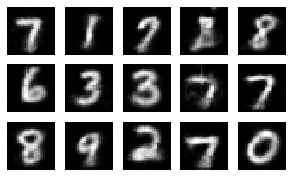

In [15]:
# save outputs as images
# decode prototype vectors
prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()
# visualize the prototype images
n_cols = 5
n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        if i*n_cols + j < n_prototypes:
            b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                    cmap='gray',
                                    interpolation='none')
            b[i][j].axis('off')                   
#plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
#                    transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

plt.close()

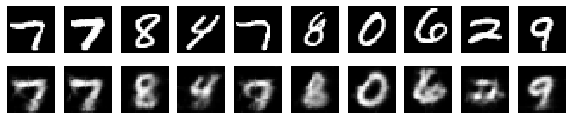

In [16]:
# apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    break

examples_to_show = 10
        
encoded = model.encoder.forward(batch_x[:examples_to_show])
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu()

# compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
    a[0][i].axis('off')
    a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
    a[1][i].axis('off')
            
#plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
#                    transparent=True,
#                    bbox_inches='tight',
#                    pad_inches=0)
plt.show()
plt.close()